<a href="https://colab.research.google.com/github/SyaidFarhan/Project_Kuliah_Syaid/blob/main/FinalProject_NLP_Kelompok2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch scikit-learn matplotlib

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Preprocessing Genia Dataset

In [ ]:
# Read GENIA Dataset
def read_genia_file(filepath):
    sentences = []
    with open(filepath, 'r') as file:
        sentence = []
        for line in file:
            line = line.strip()
            if not line or line.startswith("UI/"):
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            elif line.startswith("TI/") or line.startswith("AB/"):
                continue
            else:
                parts = re.split(r'\s+', line)
                for part in parts:
                    if '/' in part:
                        token, pos = part.rsplit('/', 1)
                        sentence.append((token, pos))
        if sentence:
            sentences.append(sentence)
    return sentences

#  Convert POS Tags to BILOU Scheme
def convert_to_bilou(sentences):
    def bilou_from_buffer(buffer):
        if len(buffer) == 1:
            return [(buffer[0][0], f"U-{buffer[0][1]}")]
        bilou_tags = []
        for i, (word, tag) in enumerate(buffer):
            if i == 0:
                bilou_tags.append((word, f"B-{tag}"))
            elif i == len(buffer) - 1:
                bilou_tags.append((word, f"L-{tag}"))
            else:
                bilou_tags.append((word, f"I-{tag}"))
        return bilou_tags

    bilou_sentences = []
    for sentence in sentences:
        bilou_sentence = []
        current_tag = None
        buffer = []
        for word, tag in sentence:
            if tag == "O":  # Directly append 'O' tags
                if buffer:
                    bilou_sentence.extend(bilou_from_buffer(buffer))
                    buffer = []
                bilou_sentence.append((word, "O"))  # Mark as Outside entity
                current_tag = None  # Reset the current tag
            elif tag == current_tag:  # Continuation of the same tag
                buffer.append((word, tag))
            else:
                if buffer:
                    bilou_sentence.extend(bilou_from_buffer(buffer))
                buffer = [(word, tag)]
                current_tag = tag
        if buffer:
            bilou_sentence.extend(bilou_from_buffer(buffer))
        bilou_sentences.append(bilou_sentence)
    return bilou_sentences


# Build Vocabularies
def build_vocab(sentences, additional_sentences=None):
    word_to_idx = {"<UNK>": 0}  # Add an <UNK> token
    tag_to_idx = {"<UNK_TAG>": 0}  # Add an <UNK_TAG> for unknown tags
    datasets = sentences if additional_sentences is None else sentences + additional_sentences

    for sentence in datasets:
        for word, tag in sentence:
            if word not in word_to_idx:
                word_to_idx[word] = len(word_to_idx)
            if tag not in tag_to_idx:
                tag_to_idx[tag] = len(tag_to_idx)
    return word_to_idx, tag_to_idx

# Bi-LSTM POS Tagging Model

In [ ]:
# Define PyTorch Dataset
class GENIADataset(Dataset):
    def __init__(self, sentences, word_to_idx, tag_to_idx):
        self.sentences = sentences
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        words = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word, tag in sentence]
        tags = [self.tag_to_idx.get(tag, self.tag_to_idx["<UNK_TAG>"]) for word, tag in sentence]
        return torch.tensor(words, dtype=torch.long), torch.tensor(tags, dtype=torch.long)

# Define  LSTM-Based POS Tagging Model
class POSTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=128):
        super(POSTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        embeddings = self.embedding(x)
        lstm_out, _ = self.lstm(embeddings)
        logits = self.fc(lstm_out)
        return logits

# Training & Validation

In [ ]:
# Training and Validation with Metrics
def train_model_with_metrics(model, train_loader, test_loader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore padding index during loss calculation

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_loss = 0
        total, correct = 0, 0
        for sentences in train_loader:
            words, tags = zip(*sentences)

            # Pad sequences for batching
            words = nn.utils.rnn.pad_sequence(words, batch_first=True, padding_value=0)
            tags = nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-1)

            # Forward pass
            outputs = model(words)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)

            # Backward pass
            optimizer.zero_grad()
            loss = criterion(outputs, tags)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(outputs, dim=-1)
            mask = tags != -1  # Ignore padding
            total += mask.sum().item()
            correct += (predictions[mask] == tags[mask]).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss, total, correct = 0, 0, 0
        with torch.no_grad():
            for sentences in test_loader:
                words, tags = zip(*sentences)
                words = nn.utils.rnn.pad_sequence(words, batch_first=True, padding_value=0)
                tags = nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-1)

                outputs = model(words)
                outputs = outputs.view(-1, outputs.shape[-1])
                tags = tags.view(-1)

                val_loss += criterion(outputs, tags).item()

                predictions = torch.argmax(outputs, dim=-1)
                mask = tags != -1  # Ignore padding
                total += mask.sum().item()
                correct += (predictions[mask] == tags[mask]).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print metrics
        print(
            f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
        )

    # Plot metrics
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Acc")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluation

In [ ]:
#
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for sentences in test_loader:
            words, tags = zip(*sentences)
            words = nn.utils.rnn.pad_sequence(words, batch_first=True, padding_value=0)
            tags = nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-1)

            outputs = model(words)
            predictions = torch.argmax(outputs, dim=-1)

            for true_tags, pred_tags in zip(tags, predictions):
                mask = true_tags != -1  # Ignore padding
                y_true.extend(true_tags[mask].tolist())
                y_pred.extend(pred_tags[mask].tolist())

    # Convert indices back to tags for evaluation
    y_true_tags = [idx_to_tag[idx].split('-')[0] for idx in y_true]  # Extract B, I, L, O, U
    y_pred_tags = [idx_to_tag[idx].split('-')[0] for idx in y_pred]  # Extract B, I, L, O, U

    # Generate classification report
    print("Classification Report (BILOU):")
    print(classification_report(y_true_tags, y_pred_tags, labels=['B', 'I', 'L', 'O', 'U'], zero_division=0))

# Main Process

Epoch 1/10 | Train Loss: 3.0557, Train Acc: 0.3326 | Val Loss: 2.1345, Val Acc: 0.4568
Epoch 2/10 | Train Loss: 1.7408, Train Acc: 0.5466 | Val Loss: 1.4703, Val Acc: 0.6170
Epoch 3/10 | Train Loss: 1.2384, Train Acc: 0.6695 | Val Loss: 1.0942, Val Acc: 0.7055
Epoch 4/10 | Train Loss: 0.9298, Train Acc: 0.7430 | Val Loss: 0.8576, Val Acc: 0.7610
Epoch 5/10 | Train Loss: 0.7331, Train Acc: 0.7898 | Val Loss: 0.7165, Val Acc: 0.7935
Epoch 6/10 | Train Loss: 0.6088, Train Acc: 0.8211 | Val Loss: 0.6279, Val Acc: 0.8160
Epoch 7/10 | Train Loss: 0.5245, Train Acc: 0.8427 | Val Loss: 0.5687, Val Acc: 0.8305
Epoch 8/10 | Train Loss: 0.4639, Train Acc: 0.8576 | Val Loss: 0.5270, Val Acc: 0.8408
Epoch 9/10 | Train Loss: 0.4176, Train Acc: 0.8700 | Val Loss: 0.4972, Val Acc: 0.8480
Epoch 10/10 | Train Loss: 0.3813, Train Acc: 0.8795 | Val Loss: 0.4743, Val Acc: 0.8568


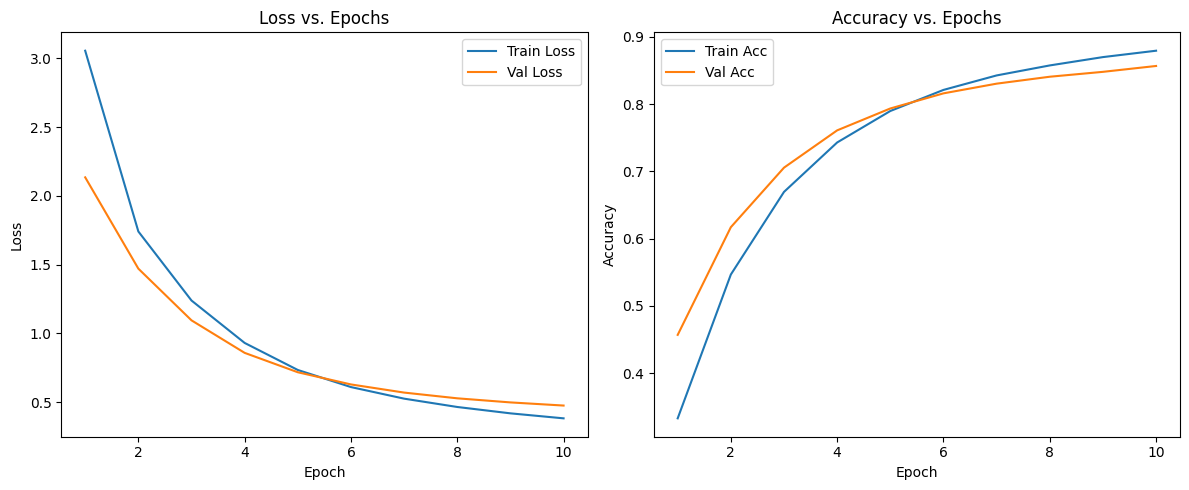

Classification Report (BILOU):
              precision    recall  f1-score   support

           B       0.64      0.40      0.49      2863
           I       0.67      0.36      0.47       797
           L       0.74      0.82      0.78      2863
           O       0.00      0.00      0.00         0
           U       0.94      0.97      0.95     32675

    accuracy                           0.91     39198
   macro avg       0.60      0.51      0.54     39198
weighted avg       0.90      0.91      0.90     39198



In [ ]:
#
train_file = '/content/GENIAtrain.pos'
test_file = '/content/GENIAtest.pos'

train_sentences = read_genia_file(train_file)
test_sentences = read_genia_file(test_file)

train_sentences = convert_to_bilou(train_sentences)
test_sentences = convert_to_bilou(test_sentences)

word_to_idx, tag_to_idx = build_vocab(train_sentences, additional_sentences=test_sentences)
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

train_dataset = GENIADataset(train_sentences, word_to_idx, tag_to_idx)
test_dataset = GENIADataset(test_sentences, word_to_idx, tag_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: x)

model = POSTagger(len(word_to_idx), len(tag_to_idx))
train_model_with_metrics(model, train_loader, test_loader, num_epochs=10)
evaluate_model(model, test_loader)
